**TODO**

ดู talk กับ history few articles เปรียบเทียบที่แปลกับต้นฉบับ ณ ขณะนี้

What types of content were added after the translation? 

Are the articles diverging in content or staying similar? 

What sorts of discussions occur on the talk pages of translated articles?

Eventually we can do this in a more robust manner: more carefully choosing which articles to examine, developing more concrete questions to answer, building a code book for annotating article histories, content, or discussions, etc.

 "has new content in the source language been added to the target language"

**TODO**

ดูได้ไหมว่านับจากวันที่ที่แปล มีการ edit กี่ครั้ง คือนับจาก timestamp ตั้งแต่วันที่แปล นับทั้งต้นทางปลายทาง อันไหนที่มี edit รวม (?) มากที่สุด
แล้วค่อยไปดูรายละเอียดว่า article ที่มีการ edit มากๆ ต่างกันมากไหม เป็น edit เล็กๆ หรือใหญ่ๆ

ดูขนาดได้ด้วย

+ loop 0-499


+ result going to be in table, column are (done)
    + sourceTitle
    + sourceRevisionId
    + targetTitle
    + translationId > targetRevisionId
    + date of creating target article
    + source edit amount since it got translated
    + target edit amount
    + source size change since it got translated
    + target size change
+ count how many times it got edit on both articles
+ give explanation on why source_edit don't have to minus 1


# Content translation from English to Thai 

## The change of source and target articles after it got translated

# Table of contents
1. [Objectives](#Objectives)
2. [Methods](#Methods)
3. [Initialization](#Initialization)
4. [Data exploration](#Dataexplo)
5. [Analyses](#Analyses)

   5.1 [Quantitative](#Quantitative)
     
      5.1.1 [The source article edit amount since it got translated](#sourceEdit)
     
      5.1.2 [The target article edit amount since the translation](#targetEdit)
        
      5.1.3 [The source article cumulative size change since the translation](#sourceSizeChange)
      
      5.1.4 [The target article cumulative size change since it the translation](#targetSizeChange)
      
      5.1.5 [Quantitative test discuession](#Quantitativedis)
      
   5.2 [Qualitative](#Qualitative)
   
      5.2.1 [Highest sourceEdit article](#Highse)
      
      5.2.2 [Highest targetEdit article](#Highte)
      
      5.2.3 [Highest sourceSizeChange article](#Highsc)
      
      5.2.4 [Highest targetSizeChange article](#Hightc)
      
      5.2.5 [Qualitative test discuession](#Qualitativedis)
      
6. [Conclusion](#Conclusion)
7. [Opportunities for furture study](#Opportunities)
8. [References](#References)
9. [Others data explore](#Others)

## Objectives <a name="Objectives"></a>
+ Count edit times and size changed of articles since the translation
+ Find the content that change after the translation
+ Find the difference and similarity in the current source and target articles when both articles have been edited

## Methods <a name="Methods"></a>
+ Quantitative
    + Use revisions API to collect source edit amount since the translation, target edit amount, source size change since the translation, and target size change since the translation
    + Create Pandas dataframe to collect and explore the result
+ Qualitative
    + The articles that have highest edit amount and the largest cumulative size change since the translation were chosen to do qualitative analysis.
    + Analize the the edit content of source and target articles since the translation by using compare selected revisions on history page on Wikipedia and see the change and the detail of the change since the translation date. 

## Initialization  <a name="Initialization"></a>

follow steps according to https://paws-public.wmflabs.org/paws-public/User:Isaac_(WMF)/Content%20Translation%20Example.ipynb#Alternative-view-of-the-data-via-Pandas

In [1]:
#imports
import gzip
import json
import re

import mwapi
import pandas as pd

import numpy as np
from numpy import nan
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
# get session for English articles
session = mwapi.Session(host='https://en.wikipedia.org',
                        user_agent='mwapi (python) -- outreachy content translation')

In [3]:
# get session for Thai articles
session_th = mwapi.Session(host='https://th.wikipedia.org',
                        user_agent='mwapi (python) -- outreachy content translation')

In [4]:
# articles translated from English -> Thai
parameters = {'action':'query',
              'format':'json',
              'list':'cxpublishedtranslations',
              'from':'en',
              'to':'th',
              'limit':500,
              'offset':2500}

# Data exploration <a name="Dataexplo"></a>

In [5]:
res = session.get(parameters)

In [6]:
df = pd.DataFrame(res['result']['translations'])
df.head(10)

,publishedDate,sourceLanguage,sourceRevisionId,sourceTitle,sourceURL,stats,targetLanguage,targetRevisionId,targetTitle,targetURL,translationId
0,20180616090318,en,846093806,Sonia Scurfield,//en.wikipedia.org/wiki/Sonia Scurfield,"{'any': 0.41319606925597, 'human': 0.313991576...",th,7678509,ซอนย่า สเกอร์ฟิลด์,//th.wikipedia.org/wiki/ซอนย่า สเกอร์ฟิลด์,491563
1,20180616092527,en,844984088,Andrew Massey (conductor),//en.wikipedia.org/wiki/Andrew Massey (conductor),"{'any': 0.92383292383292, 'human': 0.883292383...",th,7678529,แอนดี แมสซีย์ (วาทยากร),//th.wikipedia.org/wiki/แอนดี แมสซีย์ (วาทยากร),491571
2,20180616093431,en,845176394,Sam Moore (publisher),//en.wikipedia.org/wiki/Sam Moore (publisher),"{'any': 0.42849223946785, 'human': 0.428492239...",th,7678540,ซัม มัวร์ (ผู้เผยแพร่),//th.wikipedia.org/wiki/ซัม มัวร์ (ผู้เผยแพร่),491580
3,20180901233542,en,845016481,André Desvages,//en.wikipedia.org/wiki/André Desvages,"{'any': 0.59139784946237, 'human': 0.479569892...",th,7678579,อ็องเดร เดอวาก,//th.wikipedia.org/wiki/อ็องเดร เดอวาก,491589
4,20180616095938,en,845590955,Johnnie Keyes,//en.wikipedia.org/wiki/Johnnie Keyes,"{'any': 0.86713995943205, 'human': 0.735294117...",th,7678608,จอห์นนี่ คียส์,//th.wikipedia.org/wiki/จอห์นนี่ คียส์,491591
5,20180901233542,en,844509740,Robert Forhan,//en.wikipedia.org/wiki/Robert Forhan,"{'any': 0.39078498293515, 'human': 0.322525597...",th,7678635,โรเบิร์ต ฟอร์แฮน,//th.wikipedia.org/wiki/โรเบิร์ต ฟอร์แฮน,491595
6,20180901233521,en,829989743,Amand Dalem,//en.wikipedia.org/wiki/Amand Dalem,"{'any': 0.96084337349398, 'human': 0.960843373...",th,7678839,อามันด์ ดาเลม,//th.wikipedia.org/wiki/อามันด์ ดาเลม,491657
7,20180616124609,en,823655681,Édouard Ferrand,//en.wikipedia.org/wiki/Édouard Ferrand,"{'any': 0.96287703016241, 'human': 0.962877030...",th,7678856,เอดูอาร์ แฟร็อง,//th.wikipedia.org/wiki/เอดูอาร์ แฟร็อง,491660
8,20180901233519,en,823520159,Zeng Jinyan,//en.wikipedia.org/wiki/Zeng Jinyan,"{'any': 0.30705190989226, 'human': 0.215964740...",th,7678890,เจิ้ง จินย่าน,//th.wikipedia.org/wiki/เจิ้ง จินย่าน,491672
9,20180616232534,en,845477568,Jean-Baptiste Kim,//en.wikipedia.org/wiki/Jean-Baptiste Kim,"{'any': 0.617903930131, 'human': 0.61790393013...",th,7679569,จีน-บาติสต์ คิม,//th.wikipedia.org/wiki/จีน-บาติสต์ คิม,491909


#### Explore on stats column

In [7]:
df_stats = df['stats'].apply(pd.Series)
df_stats.head()

,any,human,mt,mtSectionsCount,translatedSectionsCount
0,0.413196,0.313992,0.099204,1.0,NaN
1,0.923833,0.883292,0.040541,1.0,NaN
2,0.428492,0.428492,0.000000,0.0,NaN
3,0.591398,0.479570,0.111828,1.0,NaN
4,0.867140,0.735294,0.131846,1.0,NaN


In [8]:
df_stats.describe()

,any,human,mt,mtSectionsCount,translatedSectionsCount
count,500.000000,500.000000,500.000000,500.000000,4.000000
mean,0.724505,0.628018,0.096488,1.532000,20.750000
std,0.569838,0.583701,0.240336,5.035045,17.783419
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.352576,0.239826,0.000000,0.000000,11.250000
50%,0.574587,0.440298,0.002692,1.000000,17.500000
75%,0.894474,0.834261,0.062125,1.000000,27.000000
max,4.302449,4.302449,2.862802,64.000000,45.000000


In [9]:
df_stats[df_stats['any'] > 2.5]

,any,human,mt,mtSectionsCount,translatedSectionsCount
321,3.530609,3.333557,0.197051,1.0,NaN
378,2.788609,2.788609,0.000000,0.0,NaN
379,2.508139,2.506511,0.001628,1.0,NaN
438,2.906087,0.043285,2.862802,1.0,NaN
440,2.948431,2.948431,0.000000,0.0,NaN
464,2.911345,2.852139,0.059206,1.0,NaN
481,2.570600,2.570600,0.000000,0.0,NaN
485,4.302449,4.302449,0.000000,0.0,NaN


In [10]:
df_stats[df_stats['mt'] > 1]

,any,human,mt,mtSectionsCount,translatedSectionsCount
46,1.090814,0.000000,1.090814,8.0,NaN
419,2.197262,0.060021,2.137241,1.0,NaN
438,2.906087,0.043285,2.862802,1.0,NaN


**Note1:** It can be seen that some articles has `any` (total translation percentage) and `mt` (machine translation percentage) higher than 1.
Which [Outreachy mentor explained that the number base on word count.](https://phabricator.wikimedia.org/T218003#5029680) So it is possible that word in source article is higher than translated article, resulted in `any` and `mt` higher than 1.

#### Get corresponding parallel translation

In [11]:
#Download dump to access all translated articles
json_str = ""
with gzip.open('cx-corpora.en2th.text.json.gz', 'rt', encoding='utf-8') as fin:
    for line in fin:
        json_str += line.strip()
# remove repetitive commas
json_str = re.sub(',{2,}', ',', json_str)
parallel_corpus = json.loads(json_str)

In [12]:
print("Descriptive statistics:")
print("{0} translated sections.".format(len(parallel_corpus)))
print("{0} translated articles.".format(len(set(sec['id'].split('/')[0] for sec in parallel_corpus))))

Descriptive statistics:
18281 translated sections.
2669 translated articles.


**Note2:** according to [statistic on Thai Wikipedia](https://th.wikipedia.org/w/index.php?title=%E0%B8%9E%E0%B8%B4%E0%B9%80%E0%B8%A8%E0%B8%A9:%E0%B8%AA%E0%B8%96%E0%B8%B4%E0%B8%95%E0%B8%B4&action=raw), a total articles on Thai Wikipedia are 130,431 articles (The statistic data in 20 March 2019).

#### parallel translation data explore

In [13]:
mt_counts = {}
for sec in parallel_corpus:
    if sec['mt']:
        service = sec['mt']['engine']
        mt_counts[service] = mt_counts.get(service, 0) + 1
    else:
        mt_counts['no-mt'] = mt_counts.get('no-mt', 0) + 1
print("Machine translation services used: {0}".format(mt_counts))
print("\nExample:\n", parallel_corpus[0])

Machine translation services used: {'no-mt': 16474, 'Yandex': 1642, 'Google': 165}

Example:
 {'id': '43176/mwcx-source-title', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'M25 motorway'}, 'mt': None, 'target': {'content': 'มอเตอร์เวย์เอ็ม 25'}}


# Analyses <a name="Analyses"></a>

## Quantitative <a name="Quantitative"></a>

In [14]:
#create emty dict for add data
edit_n_size_df = {'sourceTitle':[],
                            'sourceRevisionId':[],
                            'targetTitle':[],
                            'targetRevisionId':[],
                            'dateCreatingTarget':[],
                            'sourceEdit':[],
                            'targetEdit':[],
                            'sourceSizeChange':[],
                            'targetSizeChange':[]
                            }

In [15]:
#loop through 500 articles
for i in range(0,500):
    source_title = df.loc[i, 'sourceTitle']
    source_revid = df.loc[i, 'sourceRevisionId']
    target_title = df.loc[i, 'targetTitle']
    tid = df.loc[i,'targetRevisionId']
    
    edit_n_size_df['sourceTitle'].append(source_title)
    edit_n_size_df['sourceRevisionId'].append(source_revid)
    edit_n_size_df['targetTitle'].append(target_title)
    edit_n_size_df['targetRevisionId'].append(tid)
    
    # create paremeters for collect revision data from source articles
    revision_parameters_s = {
        "action": "query",
        "prop": "revisions",
        "titles": source_title,
        "rvprop": "timestamp|size|comment",
        "rvlimit": 100,
        "rvstartid": source_revid,
        "rvslots": "main",
        "formatversion": "2",
        "format": "json",
        "rvdir": "newer",
        "redirects": True
        }
    # revision data from source articles
    source_revisions = session.get(revision_parameters_s)
    
    # create paremeters for collect revision data from target articles
    revision_parameters_t = {
        "action": "query",
        "prop": "revisions",
        "titles": target_title,
        "rvprop": "timestamp|size|comment",
        "rvlimit": 100,
        "rvstartid": tid,
        "rvslots": "main",
        "formatversion": "2",
        "format": "json",
        "rvdir": "newer",
        "redirects": True
        }
    # revision data from target articles
    target_revisions = session_th.get(revision_parameters_t)
    
    # missing data
    if (target_title == "") or (('revisions' in target_revisions['query']['pages'][0])==False) or (( 'moved page' in source_revisions['query']['pages'][0]['revisions'][0]['comment']) == True) or (('missing' in target_revisions['query']['pages'][0]) == True):
        edit_n_size_df['dateCreatingTarget'].append(np.nan)
        edit_n_size_df['sourceEdit'].append(np.nan)
        edit_n_size_df['targetEdit'].append(np.nan)
        edit_n_size_df['sourceSizeChange'].append(np.nan)
        edit_n_size_df['targetSizeChange'].append(np.nan)

    else:
    
        # collect date of creating target article
        date_c_target = target_revisions['query']['pages'][0]['revisions'][0]['timestamp']
    
        # count source edit amount since it got translated
        source_edit_all = len(source_revisions['query']['pages'][0]['revisions'])    # all edit
        source_edit = 0
        for j in range(source_edit_all):
            if source_revisions['query']['pages'][0]['revisions'][j]['timestamp'] >= date_c_target:    # source edit date is higher or equal to target created date
                source_edit += 1
            
        # count target edit amount
        target_edit = len(target_revisions['query']['pages'][0]['revisions'])
    
        # find cumulative size change of source article since it got translated. Calculated by find size different between edit and sum those size different
        source_size = 0
        for r in range(source_edit):    # source_edit is also a row number of the oldest article after it got translated
            diff_size = source_revisions['query']['pages'][0]['revisions'][r+1]['size'] - source_revisions['query']['pages'][0]['revisions'][r]['size'] # newer size  - older size
            source_size += abs(diff_size) # wants to see the sum of the size that change, either decrease or increase of the size don't matter. So I put absolute there
        
        # find cumulative target size change
        target_size = 0
        for r in range(target_edit-1):    # target_edit is also a row number of target article last edit 
            diff_size = target_revisions['query']['pages'][0]['revisions'][r+1]['size'] - target_revisions['query']['pages'][0]['revisions'][r]['size'] # newer size  - older size
            target_size += abs(diff_size) # wants to see the sum of the size that change, either decrease or increase of the size don't matter. So I put absolute there
    
        # append data to dictionary
        edit_n_size_df['dateCreatingTarget'].append(date_c_target)
        edit_n_size_df['sourceEdit'].append(int(source_edit))
        edit_n_size_df['targetEdit'].append(int(target_edit))
        edit_n_size_df['sourceSizeChange'].append(int(source_size))
        edit_n_size_df['targetSizeChange'].append(int(target_size))

`dateCreatingTarget` is the date and time of article translation

`sourceEdit` is the source article edit amount since it got translated (amount of edit that happen after `dateCreatingTarget`)

`targetEdit` is  the target article edit amount since the translation

`sourceSizeChange` is the source article cumulative size change since the translation (either remove or add has been sum as positive value)

`targetSizeChange` is  the target article cumulative size change since it the translation (either remove or add has been sum as positive value)

**Note3:** in the previous code, in the loop to find `source_size` the `source_edit` didn't minus 1. However, on the `target_size` the `target_edit-1`.This because the `source_size` is the source size change since it got translated.

For example, on Sonia Scurfield article, the translation date and time (`dateCreatingTarget`) is `2018-06-16T09:03:18Z` which mean the source version that got translated is the version before that time. The `source_edit`of this article is `3` means that this article had been edit 3 times after the translation.
To compare the edit size, the size need to be compare with one version before the translation time which is on the later row (`4`). Therefore `source_edit` doesn't need to minus 1.

While `target_size` have to minus `target_edit` by 1 because the size change have to compare to the first version that was created exactly on`dateCreatingTarget`.

In [16]:
edit_n_size_pd = pd.DataFrame(edit_n_size_df)

In [17]:
edit_n_size_pd.head(5)

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
0,Sonia Scurfield,846093806,ซอนย่า สเกอร์ฟิลด์,7678509,2018-06-16T09:03:18Z,3.0,2.0,58.0,81.0
1,Andrew Massey (conductor),844984088,แอนดี แมสซีย์ (วาทยากร),7678529,2018-06-16T09:25:27Z,10.0,2.0,364.0,4.0
2,Sam Moore (publisher),845176394,ซัม มัวร์ (ผู้เผยแพร่),7678540,2018-06-16T09:34:31Z,1.0,3.0,10.0,85.0
3,André Desvages,845016481,อ็องเดร เดอวาก,7678579,2018-06-16T09:47:32Z,2.0,3.0,184.0,127.0
4,Johnnie Keyes,845590955,จอห์นนี่ คียส์,7678608,2018-06-16T09:59:38Z,10.0,3.0,434.0,340.0


In [18]:
edit_n_size_pd.tail(5)

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
495,Michael Eilberg,874054976,ไมเคิล จอร์จ ไอล์เบิร์ก,8050199,2019-01-06T03:45:58Z,0.0,3.0,0.0,83.0
496,Frank Errington,869002862,แฟรงก์ เออร์ริงตัน,8050214,2019-01-06T03:55:21Z,0.0,3.0,0.0,321.0
497,Abigail Edmonds,833951699,อบิเกล เอ็ดมอนดส์,8050220,2019-01-06T03:58:51Z,0.0,2.0,0.0,2.0
498,Barry Lillywhite,871774084,แบร์รี ลิลลิไวไฮต์,8050228,2019-01-06T04:02:16Z,0.0,3.0,0.0,113.0
499,Blake Nordstrom,877051179,เบลก นอร์ดสตรอม,8050883,2019-01-06T10:20:26Z,37.0,2.0,9024.0,2.0


In [19]:
#data describe
edit_n_size_pd.describe()

,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
count,477.000000,477.000000,477.000000,477.000000
mean,6.274633,3.433962,2016.710692,737.587002
std,16.820794,6.534840,24371.353726,3155.937485
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,18.000000,25.000000
75%,4.000000,3.000000,267.000000,144.000000
max,99.000000,100.000000,526987.000000,36104.000000


### The source article edit amount since it got translated (sourceEdit) <a name="sourceEdit"></a>

In [20]:
edit_n_size_pd.nlargest(5, ['sourceEdit','targetEdit'])

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
376,Deaths in 2019,876398709,บุคคลที่เสียชีวิตในปี พ.ศ. 2562,8042701,2019-01-02T03:20:02Z,99.0,53.0,17261.0,9057.0
51,"Cambodian general election, 2018",852318774,การเลือกตั้งทั่วไปในกัมพูชา พ.ศ. 2561,7753888,2018-07-28T23:26:29Z,99.0,18.0,17428.0,2177.0
315,Sebastian Stan,860325883,เซบาสเตียน สแตน,7875543,2018-09-30T07:08:10Z,99.0,15.0,4798.0,4445.0
327,Goblin Slayer,866058978,ก็อบลิน สเลเยอร์,7926159,2018-10-28T09:50:59Z,99.0,11.0,18664.0,5998.0
24,MacOS Mojave,847186226,macOS Mojave,7693429,2018-06-24T14:20:58Z,99.0,9.0,5469.0,546.0


In [47]:
# amount of article that have sourceEdit equal to or more than rvlimit
len(edit_n_size_pd[edit_n_size_pd['sourceEdit']==99])

7

(array([371.,  39.,  24.,   7.,   5.,   4.,   3.,   4.,   2.,   1.,   2.,
          1.,   0.,   1.,   0.,   0.,   2.,   3.,   0.,   8.]),
 array([ 0.  ,  4.95,  9.9 , 14.85, 19.8 , 24.75, 29.7 , 34.65, 39.6 ,
        44.55, 49.5 , 54.45, 59.4 , 64.35, 69.3 , 74.25, 79.2 , 84.15,
        89.1 , 94.05, 99.  ]),
 <a list of 20 Patch objects>)

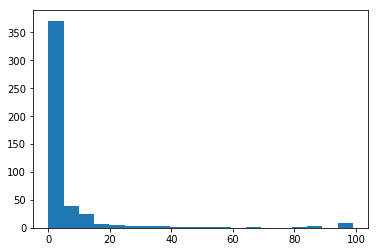

In [21]:
# Histogram of sourceEdit
plt.hist(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])], bins =20)   # exclude NaN

In [22]:
total_not_nan_se = len(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])
stat_mode_se = stats.mode(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])[0][0]
mode_freq_se = stats.mode(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])[1][0]

print('The total articles that is not NaN is '+str(total_not_nan_se))
print('Most frequent edit amount per article is '+str(stat_mode_se)+' time.')
print('The number of articles that have been edited '+str(stat_mode_se)+' time is '+str(mode_freq_se))
print('The number of articles that have been edited 1 time is '+str(len(edit_n_size_pd[edit_n_size_pd['sourceEdit']==1] )))

The total articles that is not NaN is 477
Most frequent edit amount per article is 0.0 time.
The number of articles that have been edited 0.0 time is 194
The number of articles that have been edited 1 time is 89


###  The target article edit amount since the translation (targetEdit) <a name="targetEdit"></a>

In [23]:
edit_n_size_pd.nlargest(5, 'targetEdit')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
324,List of mango cultivars,861744980,รายชื่อพันธุ์มะม่วง,7893244,2018-10-09T09:24:43Z,11.0,100.0,2203.0,5204.0
376,Deaths in 2019,876398709,บุคคลที่เสียชีวิตในปี พ.ศ. 2562,8042701,2019-01-02T03:20:02Z,99.0,53.0,17261.0,9057.0
61,Find Your Way,853018077,ไฟด์ยัวร์เวย์,7777929,2018-08-12T06:03:49Z,2.0,51.0,93.0,4567.0
345,Isan Pattaya,835833752,สโมสรฟุตบอลอีสาน ดีบีชออร่า พัทยา,7966349,2018-11-19T15:30:55Z,14.0,36.0,2164.0,26704.0
67,Under My Skin (Gabrielle album),856381641,อันเดอร์มายสกิน,7803885,2018-08-26T03:00:57Z,14.0,31.0,2698.0,5310.0


(array([432.,  27.,   6.,   3.,   3.,   1.,   1.,   1.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,   5.95,  10.9 ,  15.85,  20.8 ,  25.75,  30.7 ,  35.65,
         40.6 ,  45.55,  50.5 ,  55.45,  60.4 ,  65.35,  70.3 ,  75.25,
         80.2 ,  85.15,  90.1 ,  95.05, 100.  ]),
 <a list of 20 Patch objects>)

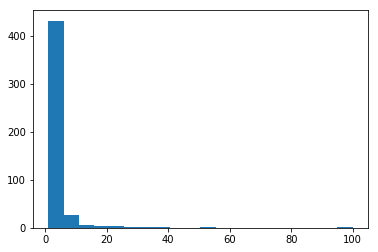

In [24]:
# Histogram of targetEdit
plt.hist(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])], bins =20)   # exclude NaN

In [25]:
total_not_nan_te = len(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])
stat_mode_te = stats.mode(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])[0][0]
mode_freq_te = stats.mode(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])[1][0]

print('The total articles that is not NaN is '+str(total_not_nan_te))
print('Most frequent edit amount per article is '+str(stat_mode_te)+' time.')
print('The number of articles that have been edited '+str(stat_mode_te)+' time is '+str(mode_freq_te))
print('The number of articles that have been edited 0 time is '+str(len(edit_n_size_pd[edit_n_size_pd['sourceEdit']==0] )))

The total articles that is not NaN is 477
Most frequent edit amount per article is 1.0 time.
The number of articles that have been edited 1.0 time is 139
The number of articles that have been edited 0 time is 194


### The source article cumulative size change since the translation (sourceSizeChange) <a name="sourceSizeChange"></a>

In [26]:
edit_n_size_pd.nlargest(5, 'sourceSizeChange')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
424,Hindenburg disaster,875776290,วินาศภัยไฮเดลเบิร์ก,8047957,2019-01-05T01:47:44Z,55.0,3.0,526987.0,125.0
34,List of Seventeen concert tours,849101456,รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน,7715180,2018-07-07T07:05:09Z,82.0,19.0,44978.0,36104.0
18,Treaty of Hudaybiyyah,846946779,สนธิสัญญาฮุดัยบิยะฮ์,7723118,2018-07-11T13:59:17Z,81.0,1.0,39781.0,0.0
43,Bongbong Marcos,849969829,บองบอง มาร์กอส,7728170,2018-07-14T12:09:29Z,87.0,3.0,22279.0,83.0
327,Goblin Slayer,866058978,ก็อบลิน สเลเยอร์,7926159,2018-10-28T09:50:59Z,99.0,11.0,18664.0,5998.0


(array([474.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0.  ,  26349.35,  52698.7 ,  79048.05, 105397.4 , 131746.75,
        158096.1 , 184445.45, 210794.8 , 237144.15, 263493.5 , 289842.85,
        316192.2 , 342541.55, 368890.9 , 395240.25, 421589.6 , 447938.95,
        474288.3 , 500637.65, 526987.  ]),
 <a list of 20 Patch objects>)

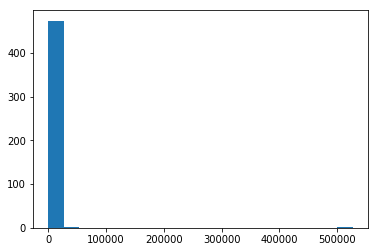

In [27]:
# Histogram of sourceSizeChange
plt.hist(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])], bins =20)   # exclude NaN

In [28]:
total_not_nan_sc = len(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])
stat_mode_sc = stats.mode(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])[0][0]
mode_freq_sc = stats.mode(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])[1][0]
median_sc = np.median(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])

print('The total articles that is not NaN is '+str(total_not_nan_sc))
print('Most frequent size change per article is '+str(stat_mode_sc)+' byte.')
print('The number of articles that have total size change equal to '+str(stat_mode_sc)+'byte is '+str(mode_freq_sc))
print('The median of size chage is '+str(median_sc )+' bytes.')

The total articles that is not NaN is 477
Most frequent size change per article is 0.0 byte.
The number of articles that have total size change equal to 0.0byte is 203
The median of size chage is 18.0 bytes.


###  The target article cumulative size change since it the translation (targetSizeChange) <a name="targetSizeChange"></a>

In [29]:
edit_n_size_pd.nlargest(5, 'targetSizeChange')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
34,List of Seventeen concert tours,849101456,รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน,7715180,2018-07-07T07:05:09Z,82.0,19.0,44978.0,36104.0
352,List of legislatures by number of members,869603280,รายชื่อสภานิติบัญญัติแห่งชาติตามจำนวนสมาชิก,7982431,2018-11-28T11:46:26Z,3.0,5.0,123.0,29282.0
345,Isan Pattaya,835833752,สโมสรฟุตบอลอีสาน ดีบีชออร่า พัทยา,7966349,2018-11-19T15:30:55Z,14.0,36.0,2164.0,26704.0
354,List of countries by body mass index,870854912,รายชื่อประเทศเรียงตามดัชนีมวลกาย,7982462,2018-11-28T12:13:27Z,36.0,8.0,898.0,22626.0
92,List of elevation extremes by country,853994442,รายชื่อประเทศเรียงตามระดับความสูง,7826515,2018-09-06T13:30:46Z,22.0,7.0,1374.0,19504.0


(array([441.,  12.,   8.,   3.,   3.,   4.,   0.,   0.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([    0. ,  1805.2,  3610.4,  5415.6,  7220.8,  9026. , 10831.2,
        12636.4, 14441.6, 16246.8, 18052. , 19857.2, 21662.4, 23467.6,
        25272.8, 27078. , 28883.2, 30688.4, 32493.6, 34298.8, 36104. ]),
 <a list of 20 Patch objects>)

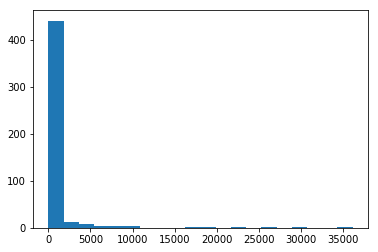

In [30]:
# Histogram of targetSizeChange
plt.hist(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])], bins =20)   # exclude NaN

In [31]:
total_not_nan_tc = len(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])
stat_mode_tc = stats.mode(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[0][0]
mode_freq_tc = stats.mode(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[1][0]
median_tc = np.median(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])

print('The total articles that is not NaN is '+str(total_not_nan_tc))
print('Most frequent size change per article is '+str(stat_mode_tc)+' byte.')
print('The number of articles that have total size change equal to '+str(stat_mode_tc)+' byte is '+str(mode_freq_tc))
print('The median of size chage is '+str(median_tc)+' bytes.')

The total articles that is not NaN is 477
Most frequent size change per article is 0.0 byte.
The number of articles that have total size change equal to 0.0 byte is 152
The median of size chage is 25.0 bytes.


#### The graph between edit and size change

Text(0.5,1,'targetEdit vs targetSizeChange')

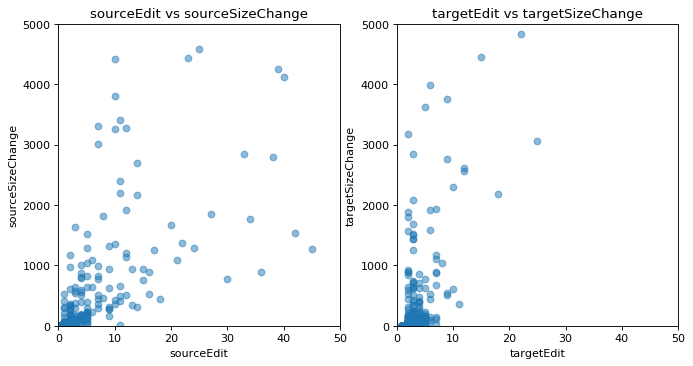

In [32]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80)

plt.subplot(1,2,1)
plt.scatter(edit_n_size_pd['sourceEdit'],edit_n_size_pd['sourceSizeChange'], alpha = 0.5)
plt.xlim(0,50)
plt.ylim(0, 5000)
plt.xlabel('sourceEdit')
plt.ylabel('sourceSizeChange')
plt.title('sourceEdit vs sourceSizeChange')

plt.subplot(1,2,2)
plt.scatter(edit_n_size_pd['targetEdit'],edit_n_size_pd['targetSizeChange'],alpha = 0.5)
plt.xlim(0,50)
plt.ylim(0, 5000)
plt.xlabel('targetEdit')
plt.ylabel('targetSizeChange')
plt.title('targetEdit vs targetSizeChange')

#### The graph between source edit and target edit, and between source size change and target size change

Text(0.5,1,'sourceSizeChange vs targetSizeChange')

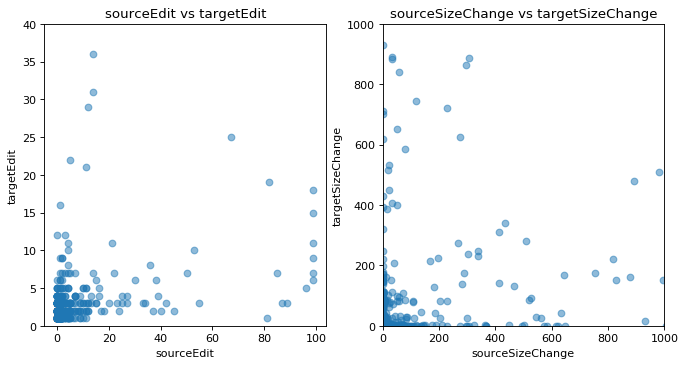

In [33]:
figure(num=None, figsize=(10, 5), dpi=80)

plt.subplot(1,2,1)
plt.scatter(edit_n_size_pd['sourceEdit'],edit_n_size_pd['targetEdit'], alpha = 0.5)
plt.ylim(0, 40)
plt.xlabel('sourceEdit')
plt.ylabel('targetEdit')
plt.title('sourceEdit vs targetEdit')

plt.subplot(1,2,2)
plt.scatter(edit_n_size_pd['sourceSizeChange'],edit_n_size_pd['targetSizeChange'], alpha = 0.5)
plt.xlim(0,1000)
plt.ylim(0, 1000)
plt.xlabel('sourceSizeChange')
plt.ylabel('targetSizeChange')
plt.title('sourceSizeChange vs targetSizeChange')

### Quantitative test discuession <a name="Quantitativedis"></a>
From the data describe table, there are 477 articles that have no missing data. the maximum `sourceEdit` is 99, and the maximum `targetEdit` is 100 because on the  paremeters for collect revision data the rvlimit was setted to 100. And the maximum `sourceEdit` is 99 because how the `sourceEdit` and  `targetEdit` was calculated (see note2) so it less than 100 by 1.

It can be seen from all histogram graph that most of the number of edit or change size are concentrated on the lower number. The majority of edit amount on source articles and target articles is either 0 or 1 time. The most frequent size change per article on source article size change and target article size change is 0 byte. Therefore, after the translation, most articles have little to no change.

On the other hand, seven source articles and one target article have edit equal to or more than rvlimit. For the size change, the largest cumulative size change of source article is 526087 bytes and for target article is 36104 bytes. Those articles were looked into the change details in qualitative part.

According to the graph between edit and size change, the trend couldn't be identify. Some of articles have high edit amount but low size change, while some of articles  have high edit amount and high size change. Therefore, it cannot be conclude that the size change is vary according to edit amount.

Similar to the graph between edit and size change, the trend between source edit and target edit, and between source size change and target size change cannot be identify.

## Qualitative <a name="Qualitative"></a>

The articles that have highest `sourceEdit`, `targetEdit`, `sourceSizeChange`, and `targetSizeChange` were chosen to do qualitative analysis

###  Highest sourceEdit article <a name="Highse"></a>
Reminding that `sourceEdit` was count from the day that the source article got translated into Thai ariticle (from `dateCreatingTarget`), since the objective is to see the difference and similarity in both articles after translation.

Make sense that Deaths in 2019 have high edit because 2019 is this current year.

In [34]:
pd.options.display.max_colwidth = 100    # to view long URL
df[['sourceURL','targetURL']][df['sourceTitle'] == 'Deaths in 2019']

,sourceURL,targetURL
376,//en.wikipedia.org/wiki/Deaths in 2019,//th.wikipedia.org/wiki/บุคคลที่เสียชีวิตในปี พ.ศ. 2562


From the quantitative part, because there are more than one article that have edit equal to or more than rvlimit, the article that also have high target edit was selected for investigation in this part which is article **"Deaths in 2019"**. The source article (English) has cumulative size change 44978 bytes. The target article (Thai) has been edit 53 times with cumulative size change 36104 bytes.

Since this is the article about on going year, both article still update over time. Not all of edit in English article were updated in Thai article. The length of both article are different. English article was splited by date and month, while Thai article was split by month and order by date. Thai well known who death in 2019 were added in Thai article, but only one Thai well known was added in English article.
Interesting that the Deaths in 2019 Thai article was created by translating from English article, while [Deaths in 2018](https://th.wikipedia.org/wiki/%E0%B8%9A%E0%B8%B8%E0%B8%84%E0%B8%84%E0%B8%A5%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%80%E0%B8%AA%E0%B8%B5%E0%B8%A2%E0%B8%8A%E0%B8%B5%E0%B8%A7%E0%B8%B4%E0%B8%95%E0%B9%83%E0%B8%99%E0%B8%9B%E0%B8%B5_%E0%B8%9E.%E0%B8%A8._2561) Thai article was not. Both English and Thai articles were edited by multiple editors.

The talk section on English article has a lot of discussion, FAQ and guideline. While Thai article has no activity.

###  Highest targetEdit article  <a name="Highte"></a>


In [35]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'List of mango cultivars']

,sourceURL,targetURL
324,//en.wikipedia.org/wiki/List of mango cultivars,//th.wikipedia.org/wiki/รายชื่อพันธุ์มะม่วง


The target article that have highest edit amount is **List of mango cultivars** which have been edit for equal to 100 or more times with a cumulative size change 2203 bytes. While the source of this article was edited 11 times with a cumulative size change 5204 bytes.

At the transation ,all of the content in English got translate into Thai. No missing content was left untranslated. After the translation (since 18:17, 29 September 2018 which is the version of source article that got translated), there are some typo edited to the English article and added more cultivars such as Paige, Pickering, Pram Kai Mea, Rosa with some information. 

While Thai article only had minor edit. For example, changed transliterated country and cultivars names into Thai, changed links inside article from  English to Thai Wikipedia articles, added country name to sentence that had only state name (where in English article don't have country name in the same sentence). The cultivars that were added in English article was not added into Thai article.

Unlike English article that has multiple editors, in Thai article almost all change come from a single editor. Moreover, the Thai article got edited in a close time and had small change per edit, which is the reason of high target edited amount in this article.

There are discussion in the English article talk page about article pattern, data add, tag add. However, no talk create in 2018 and 2019. While talk page of Thai article has no activity.

###  Highest sourceSizeChange article <a name="Highsc"></a>
Similar to `sourceEdit`, `sourceSizeChange` also count from the day that the source article got translated into Thai ariticle.


In [36]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'Hindenburg disaster']

,sourceURL,targetURL
424,//en.wikipedia.org/wiki/Hindenburg disaster,//th.wikipedia.org/wiki/วินาศภัยไฮเดลเบิร์ก


The source article that have highest cumulative size change is **Hindenburg disaster** which has 526087 bytes changed in 47 edits. While the target article has only 125 bytes changed in 3 edits.

Since 28 December 2018  (the version of source article that got translated), English article was edited to changed coding, fixed typo, fixed grammar,  added references and data with references, and change URL references in the article. The english article also has multiple revert edit. It was revert with  possible vandalism reason for 3 times. The talk page in English article has high contents. The talk after 28 December 2018 is about adding reference from a movie. This content on the talk also had been edit into the article.

Compare to English article, Thai article is not completed. Only the first paragraph got translated. The edits in Thai article just fixed typos and pattern. Which consistent with low edit amounts and low bytes changed on target ariticle. No talk on the talk page.

In addition, the English article of Hindenburg disaster has unregistered editing more than Deaths in 2019, List of mango cultivars, and List of Seventeen concert tours English articles.

###  Highest targetSizeChange article <a name="Hightc"></a>

In [37]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'List of Seventeen concert tours']

,sourceURL,targetURL
34,//en.wikipedia.org/wiki/List of Seventeen concert tours,//th.wikipedia.org/wiki/รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน


The target article that have highest cumulative size change is **List of Seventeen concert tours** which has 36104 bytes changed in 19 edits. While the source article has 44978 bytes changed in 82 edits.

Seventeen is an active boy band, therefore new contents are expected to be added. In english article more infomation was added since 6 July 2018 (the version of source article that got translated), for example, information about consert date, fanmeeting, and minor edited on typo.

When compare Thai article to the 6 July 2018 English ariticle, The translation to Thai was not completed. Only the first paragraph and the first table were translated. The later updated in Thai article was translations from English article from  6 July 2018 version. Therefore, no update made in English article was added into Thai article. Other than translation was a minor edited.

There were about two regular editors in English article while in Thai article was frequently edit by one person.

The talk page in English article has one discussion about deleting related article on 2017, no other article from 2018 and 2019. Thai talk page don't have any discussion.

### Qualitative test discuession <a name="Qualitativedis"></a>

According to the chosen articles, all four articles in English version (source article) had new updates since the translation. The edits in English articles were added new information and other minor edited such as changed coding, fixed grammar or added references. Thai articles also had minor edited, however, only one Thai article had more information updated which is "Deaths in 2019". The updated contents in "Deaths in 2019" ariticle still not the same as updated content in English article. This probably because the well known persons of two groups are different. English articles usually have multiple editors that edited the pages, but Thai articles have only one or two editors.

# Conclusion <a name="Conclusion"></a>
From total wikipedia 130,431 articles, 2670 articles was translated by using parallel translation. ( **TODO** check number again)
The total translated sections are 18300, most of the translation are from human (16474) the rest was translated from machine translation services (from Yandex 1642, from Google 183, from scratch 1). From 477 articles that not have missing data, most of the articles in source and target articles have small amount of edit amount and size change since the translation date. Seven source articles and one target article have edit equal to or more than rvlimit. The largest cumulative size change of source article is 526087 bytes and for the target article is 36104 bytes. The relationship between edit and size change, source edit and target edit, and between source size change and target size change cannot be identify. In qualitative analysis, all English articles that were explored have new content added since the translation date. While apart from minor edited, only one Thai article has new content. The other three articles have no new content added.
It is dificult to see the change in English articles when it get update since the translated date. The tool for editor which help compare both version may make it easier to see update contents which can be update into Thai articles.

## Opportunities for furture study <a name="Opportunities"></a>
+ Use revisions API to collect comments to see what kind of words were used frequently in the comments
+ Use revisions API to see which kind of article were edited by anonymous or regular users
+ Use revisions API to collect target size change per edit data. Then compare small size edit (possibly typo fixed) to large size edit (possibly significant data changed) 
+ Use page view API to compare page views between source and target articles

##  References <a name="References"></a>
https://paws-public.wmflabs.org/paws-public/User:Isaac_(WMF)/Content%20Translation%20Example.ipynb#Alternative-view-of-the-data-via-Pandas
https://phabricator.wikimedia.org/T218003#5029680
https://th.wikipedia.org/w/index.php?title=%E0%B8%9E%E0%B8%B4%E0%B9%80%E0%B8%A8%E0%B8%A9:%E0%B8%AA%E0%B8%96%E0%B8%B4%E0%B8%95%E0%B8%B4&action=raw
https://www.mediawiki.org/wiki/API:Revisions
https://www.mediawiki.org/wiki/Content_translation/Published_translations#List_of_published_source_and_target_titles

---

### Others data explore <a name="Others"></a>

In [38]:
df[['sourceTitle','targetTitle']][:30]

,sourceTitle,targetTitle
0,Sonia Scurfield,ซอนย่า สเกอร์ฟิลด์
1,Andrew Massey (conductor),แอนดี แมสซีย์ (วาทยากร)
2,Sam Moore (publisher),ซัม มัวร์ (ผู้เผยแพร่)
3,André Desvages,อ็องเดร เดอวาก
4,Johnnie Keyes,จอห์นนี่ คียส์
5,Robert Forhan,โรเบิร์ต ฟอร์แฮน
6,Amand Dalem,อามันด์ ดาเลม
7,Édouard Ferrand,เอดูอาร์ แฟร็อง
8,Zeng Jinyan,เจิ้ง จินย่าน
9,Jean-Baptiste Kim,จีน-บาติสต์ คิม


##### The Holy city article

In [39]:
df[df['sourceTitle'] == 'Holy city']

,publishedDate,sourceLanguage,sourceRevisionId,sourceTitle,sourceURL,stats,targetLanguage,targetRevisionId,targetTitle,targetURL,translationId
20,20180625112801,en,845754238,Holy city,//en.wikipedia.org/wiki/Holy city,"{'any': 0.8185914552737, 'human': 0.81692256341789, 'mt': 0.0016688918558077, 'mtSectionsCount': 1}",th,7694813,เมืองศักดิ์สิทธิ์,//th.wikipedia.org/wiki/เมืองศักดิ์สิทธิ์,492437


In [40]:
holyc_source_title = df.loc[20, 'sourceTitle']
holyc_target_title = df.loc[20, 'targetTitle']
holyc_tid = df.loc[20,'translationId']
holyc_source_revid = df.loc[20, 'sourceRevisionId']
print(holyc_source_title)
print(holyc_target_title)
print(holyc_tid)
print(holyc_source_revid)

Holy city
เมืองศักดิ์สิทธิ์
492437
845754238


In [41]:
# Translated sections for "Holy city" article
for translated_section in parallel_corpus:
    if translated_section['id'].split('/')[0] == holyc_tid:
        print(translated_section, '\n')

{'id': '492437/69824d3b0e70ca6aaa0da1613b65fd', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'References'}, 'mt': {'engine': 'Yandex', 'content': 'อ้างอิง'}, 'target': {'content': 'References'}} 

{'id': '492437/0f5fbbd8e643b1b08a782d4e206f94', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'South Asia'}, 'mt': None, 'target': {'content': 'เอเชียใต้'}} 

{'id': '492437/2d1b84c3b2d1353bb8d6c146558555', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'Americas'}, 'mt': None, 'target': {'content': 'อเมริกา'}} 

{'id': '492437/37ee626c09bb4ac040663fda7879ea', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'West Asia'}, 'mt': None, 'target': {'content': 'เอเชียตะวันตก'}} 

{'id': '492437/6f202f54a7b2d8fe42aa804eabe48e', 'sourceLanguage': 'en', 'targetLanguage': 'th', 'source': {'content': 'List'}, 'mt': None, 'target': {'content': 'รายชื่อเมืองศักดิ์สิทธิ์ทั่วโลก'}} 

{'id': '492437/a5893730881df686